In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Load the data
data = pd.read_csv('Annotated_data.csv')

# undersample the "no distortion" class so there's only 250 samples
no_distortion = data[data['Dominant Distortion'] == 'No Distortion']
distortion = data[data['Dominant Distortion'] != 'No Distortion']
no_distortion = no_distortion.sample(n=250, random_state=42)
data = pd.concat([no_distortion, distortion])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Patient Question'], data['Dominant Distortion'], test_size=0.2, random_state=42)

# Create a label encoder object
le = LabelEncoder()

# Fit the encoder to the training labels
y_train_encoded = le.fit_transform(y_train)

# Transform the testing labels
y_test_encoded = le.transform(y_test)

# Create the vectorizer and model objects
vectorizer = CountVectorizer()
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), n_jobs=-1, colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5)

# Preprocess the text data and vectorize using the provided vectorizer
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train the model on the training data
model.fit(X_train_vectorized, y_train_encoded)

# Predict the labels for the testing data
y_pred = model.predict(X_test_vectorized)

# Calculate the F1-score
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

# Output the F1-score
print(f"F1-score: {f1}")

# f1 before using best parameters: 0.1926
# f1 after using best parameters: 0.172

F1-score: 0.1719859377256203


In [6]:
# hyperparameter tuning on XGBoost using undersampled data
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, HalvingGridSearchCV

# Create a dictionary of parameters to test using only arrays
params = {
    'learning_rate': [0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'min_child_weight': [1, 3]
    
}

"""

    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'min_child_weight': [1, 3]
"""

# Create a HalvingGridSearchCV and a RandomizedSearchCV object with the model and vectorizer
search = HalvingGridSearchCV(xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), n_jobs=-1), params, cv=5, n_jobs=-1, verbose=1)
#search = RandomizedSearchCV(xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), n_jobs=-1), params, n_iter=100, cv=5, n_jobs=-1, verbose=1)

# Train and test the model
search.fit(X_train_vectorized, y_train_encoded)

# Predict the labels for the testing data
y_pred = search.predict(X_test_vectorized)

# Calculate the F1-score
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

# Output the F1-score
print(f"F1-score: {f1}")

# Print the best parameters
print(search.best_params_)

n_iterations: 3
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 110
max_resources_: 1477
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 162
n_resources: 110
Fitting 5 folds for each of 162 candidates, totalling 810 fits
----------
iter: 1
n_candidates: 54
n_resources: 330
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 2
n_candidates: 18
n_resources: 990
Fitting 5 folds for each of 18 candidates, totalling 90 fits
F1-score: 0.16393040345996615
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1}


In [3]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, HalvingGridSearchCV

def tuneParams(model, params, X_train, y_train, X_test, y_test):
    # Create a HalvingGridSearchCV and a RandomizedSearchCV object with the model and vectorizer
    search = HalvingGridSearchCV(model, params, cv=5, n_jobs=-1, verbose=1)
    #search = RandomizedSearchCV(model, params, n_iter=100, cv=5, n_jobs=-1, verbose=1)

    # Train and test the model
    search.fit(X_train, y_train)

    # Predict the labels for the testing data
    y_pred = search.predict(X_test)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict the labels for the testing data
    y_pred = model.predict(X_test)

    # Calculate the F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Output the F1-score
    print(f"{model.__class__.__name__} F1-score: {f1}")

    # Print the best parameters
    print(search.best_params_)
    return f1

In [23]:
# Create a label encoder object
le = LabelEncoder()

# Fit the encoder to the training labels
y_train_encoded = le.fit_transform(y_train)

# Transform the testing labels
y_test_encoded = le.transform(y_test)
tuneParams(xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), n_jobs=-1), params, X_train_vectorized, y_train_encoded, X_test_vectorized, y_test_encoded)

n_iterations: 3
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 110
max_resources_: 1477
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 162
n_resources: 110
Fitting 5 folds for each of 162 candidates, totalling 810 fits
----------
iter: 1
n_candidates: 54
n_resources: 330
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 2
n_candidates: 18
n_resources: 990
Fitting 5 folds for each of 18 candidates, totalling 90 fits
XGBClassifier F1-score: 0.192562687169555
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1}


In [5]:
# turn parameters of LinearSVC
from sklearn.svm import LinearSVC

vectorizer = TfidfVectorizer()
model = LinearSVC(C=1)

X_train, X_test, y_train, y_test = train_test_split(data['Patient Question'], data['Dominant Distortion'], test_size=0.2, random_state=42)

# Preprocess the text data and vectorize using the provided vectorizer
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train the model on the training data
model.fit(X_train_vectorized, y_train)

# Predict the labels for the testing data
y_pred = model.predict(X_test_vectorized)

# Calculate the F1-score
f1 = f1_score(y_test, y_pred, average='weighted')

# Output the F1-score
print(f"F1-score: {f1}")


tuneParams(LinearSVC(), {'C': [0.1, 1, 10, 100]}, X_train_vectorized, y_train, X_test_vectorized, y_test)

c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


F1-score: 0.2249733229713054
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 425
max_resources_: 1277
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 425
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 1275
Fitting 5 folds for each of 2 candidates, totalling 10 fits
LinearSVC F1-score: 0.2249733229713054
{'C': 0.1}


c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.2249733229713054

In [4]:
# Load the data
data = pd.read_csv('Annotated_data.csv')

# train with no non-distortion data
distortion = data[data['Dominant Distortion'] != 'No Distortion']
data = distortion

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Patient Question'], data['Dominant Distortion'], test_size=0.2, random_state=42)

# Create a label encoder object
le = LabelEncoder()

# Fit the encoder to the training labels
y_train_encoded = le.fit_transform(y_train)

# Transform the testing labels
y_test_encoded = le.transform(y_test)

# Create the vectorizer and model objects
vectorizer = CountVectorizer()
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), n_jobs=-1, colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5)

# Preprocess the text data and vectorize using the provided vectorizer
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# hyperparameter tuning on XGBoost using undersampled data
tuneParams(xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), n_jobs=-1), params, X_train_vectorized, y_train_encoded, X_test_vectorized, y_test_encoded)

NameError: name 'params' is not defined

In [5]:
# tune parameters of LinearSVC using sentence transformer model
from sentence_transformers import SentenceTransformer
from sklearn.svm import LinearSVC

# Load the data
data = pd.read_csv('Annotated_data.csv')
distortion_data = data[data['Dominant Distortion'] != 'No Distortion']
distortion_data = distortion_data.reset_index(drop=True)

# Load the SentenceTransformer model
vectorizer = SentenceTransformer('intfloat/multilingual-e5-large-instruct', cache_folder="N:\AI\Transformers_cache")
model = LinearSVC(C=1)

X_train, X_test, y_train, y_test = train_test_split(distortion_data['Patient Question'], distortion_data['Dominant Distortion'], test_size=0.2, random_state=42)

# Preprocess the text data and vectorize using the provided vectorizer
X_train_vectorized = vectorizer.encode(X_train.tolist())
X_test_vectorized = vectorizer.encode(X_test.tolist())

# Train the model on the training data
model.fit(X_train_vectorized, y_train)

# Predict the labels for the testing data
y_pred = model.predict(X_test_vectorized)

# Calculate the F1-score
f1 = f1_score(y_test, y_pred, average='weighted')

# Output the F1-score
print(f"F1-score: {f1}")


tuneParams(LinearSVC(), {'C': [0.5, 1, 2, 5]}, X_train_vectorized, y_train, X_test_vectorized, y_test)

c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


F1-score: 0.3093231897504867
Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC F1-score: 0.3093231897504867
{'C': 0.5}


In [6]:
tuneParams(LinearSVC(), {'C': [x / 10.0 for x in range(1, 15, 1)]}, X_train_vectorized, y_train, X_test_vectorized, y_test)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 141
max_resources_: 1277
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 14
n_resources: 141
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 1
n_candidates: 5
n_resources: 423
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 2
n_resources: 1269
Fitting 5 folds for each of 2 candidates, totalling 10 fits
LinearSVC F1-score: 0.2249733229713054
{'C': 1.0}


c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.2249733229713054

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

vectorizer = SentenceTransformer('intfloat/multilingual-e5-large-instruct', cache_folder="N:\AI\Transformers_cache")
#vectorizer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
model1 = LogisticRegression()
model2 = LinearSVC()

data = pd.read_csv('Annotated_data.csv')
distortion_data = data[data['Dominant Distortion'] != 'No Distortion']
distortion_data = distortion_data.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(distortion_data['Patient Question'], distortion_data['Dominant Distortion'], test_size=0.2, random_state=42)

# Preprocess the text data and vectorize using the provided vectorizer
X_train_vectorized = vectorizer.encode(X_train.tolist())
X_test_vectorized = vectorizer.encode(X_test.tolist())

logisticRParams = {'C': [0.5, 1, 2, 5]}
LinearSVCparams = {'C': [0.5, 1, 2, 5]}

tuneParams(LinearSVC(), {'C': [x / 10.0 for x in range(1, 10, 1)]}, X_train_vectorized, y_train, X_test_vectorized, y_test)
tuneParams(LogisticRegression(), {'C': [x / 10.0 for x in range(15, 28, 1)]}, X_train_vectorized, y_train, X_test_vectorized, y_test)


c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 141
max_resources_: 1277
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 141
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 423
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 1269
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC F1-score: 0.26179470874658695
{'C': 0.7}
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 141
max_resources_: 1277
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 13
n_resources: 141
Fitting 5 folds for each of 13 candidates, totalling 65 fits
----------
iter: 1
n_candidates: 5
n_resources: 423
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 2
n_resources: 1269
Fitting 5 folds for each of 2 candidates, totalling 10 fits
LogisticRegression F1-score: 0.18724998377328889
{'C': 2.0}


0.18724998377328889

In [8]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Create an array of models to test
models = [
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    SVC(),
    LinearSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    MLPClassifier()
]

# Create an array of model parameters to test
params = [
    {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
    {'C': [2.6]},
    {'alpha': [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003]},
    {'C': [1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]},
    {'C': [0.4, 0.5, 0.6]},
    {'max_depth': [1, 2, 3, 4, 5 ]},
    {'n_estimators': [70, 80, 90, 100, 110, 120, 130, 140]},
    {'n_estimators': [35, 40, 45, 50, 55, 60, 65, 70, 75]},
    {'n_neighbors': [10, 11, 12, 13, 14, 16, 18, 20]},
    {'alpha': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]}
]

# store the F1-scores
f1_scores = []

# test all models
for i in range(len(models)):
    f1 = tuneParams(models[i], params[i], X_train_vectorized, y_train, X_test_vectorized, y_test)
    f1_scores.append(f1)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 141
max_resources_: 1277
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 141
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 423
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 1269
Fitting 5 folds for each of 1 candidates, totalling 5 fits
BernoulliNB F1-score: 0.16974170813239736
{'alpha': 0.9}
n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 1277
max_resources_: 1277
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 1277
Fitting 5 folds for each of 1 candidates, totalling 5 fits
LogisticRegression F1-score: 0.18724998377328889
{'C': 2.6}
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 425
max_resources_: 1277
aggressive_elimination: False
fac

c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC F1-score: 0.26179470874658695
{'C': 0.5}
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 425
max_resources_: 1277
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 5
n_resources: 425
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 1
n_candidates: 2
n_resources: 1275
Fitting 5 folds for each of 2 candidates, totalling 10 fits
DecisionTreeClassifier F1-score: 0.15438707177912808
{'max_depth': 3}
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 425
max_resources_: 1277
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 425
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 3
n_resources: 1275
Fitting 5 folds for each of 3 candidates, totalling 15 fits
RandomForestClassifier F1-score: 0.1434124877576745
{'n_estimators': 140}
n_iterations: 3
n_required_iterations: 3
n_possible_iteration

c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier F1-score: 0.2645564118372438
{'alpha': 0.25}


c:\Users\meaps\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [28]:
# try XGBoost with sentence transformer
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()

# Fit the encoder to the training labels
y_train_encoded = le.fit_transform(y_train)

# Transform the testing labels
y_test_encoded = le.transform(y_test)

# Create the vectorizer and model objects
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), n_jobs=-1, colsample_bytree=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5)

# Parameters to tune
params = {
    'learning_rate': [0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'min_child_weight': [1, 3]
}

# Train and test the model
f1 = tuneParams(model, params, X_train_vectorized, y_train_encoded, X_test_vectorized, y_test_encoded)

# Output the F1-score
print(f"F1-score: {f1}")

# Add the F1-score to the list
f1_scores.append(f1)

n_iterations: 3
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 110
max_resources_: 2024
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 162
n_resources: 110
Fitting 5 folds for each of 162 candidates, totalling 810 fits
----------
iter: 1
n_candidates: 54
n_resources: 330
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 2
n_candidates: 18
n_resources: 990
Fitting 5 folds for each of 18 candidates, totalling 90 fits
XGBClassifier F1-score: 0.25896681047453335
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.5}
F1-score: 0.25896681047453335


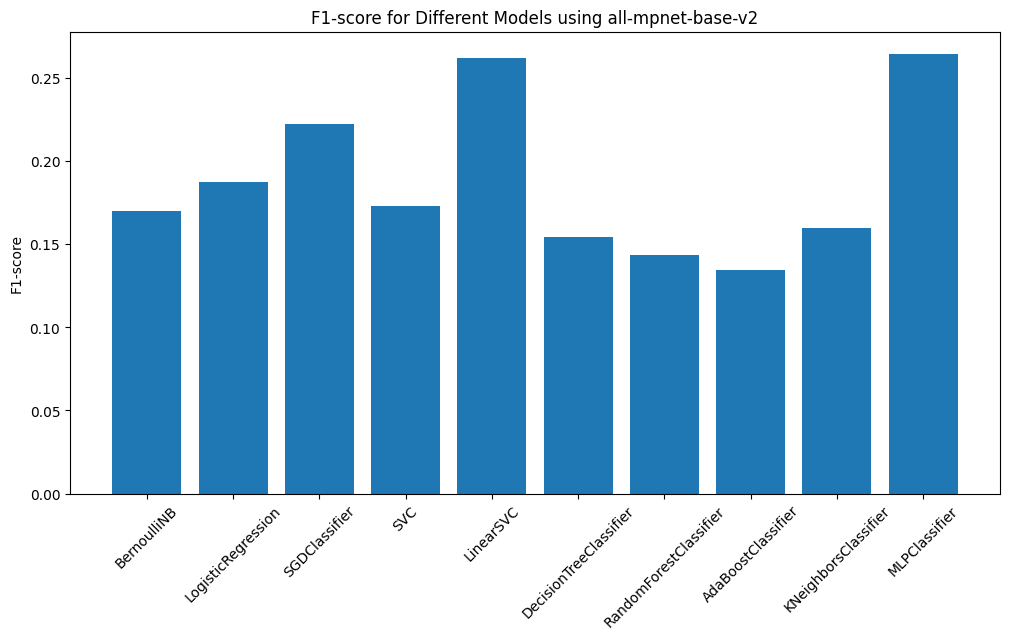

In [9]:
# graph the F1-scores
plt.figure(figsize=(12, 6))
plt.bar([model.__class__.__name__ for model in models], f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1-score')
plt.title('F1-score for Different Models using all-mpnet-base-v2')
plt.show()